<a href="https://colab.research.google.com/github/rohith033/oelp/blob/master/book_det_model3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
import cv2 
import numpy as np 
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf


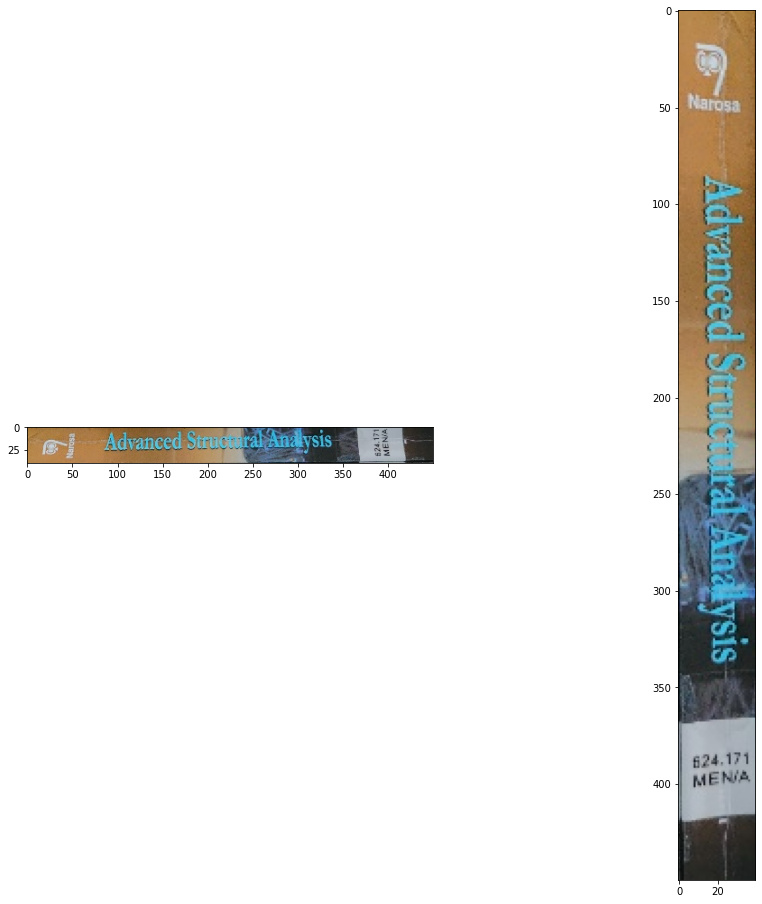

In [ ]:
img = cv2.imread('./book3.jpeg')
tmp=[]
tmp.append(img)
rot = cv2.rotate(img,cv2.ROTATE_90_CLOCKWISE)
tmp.append(rot)
fig,axies = plt.subplots(1,2,figsize=(16,16))
for i,ax in enumerate(axies.flat):
  ax.imshow(tmp[i])

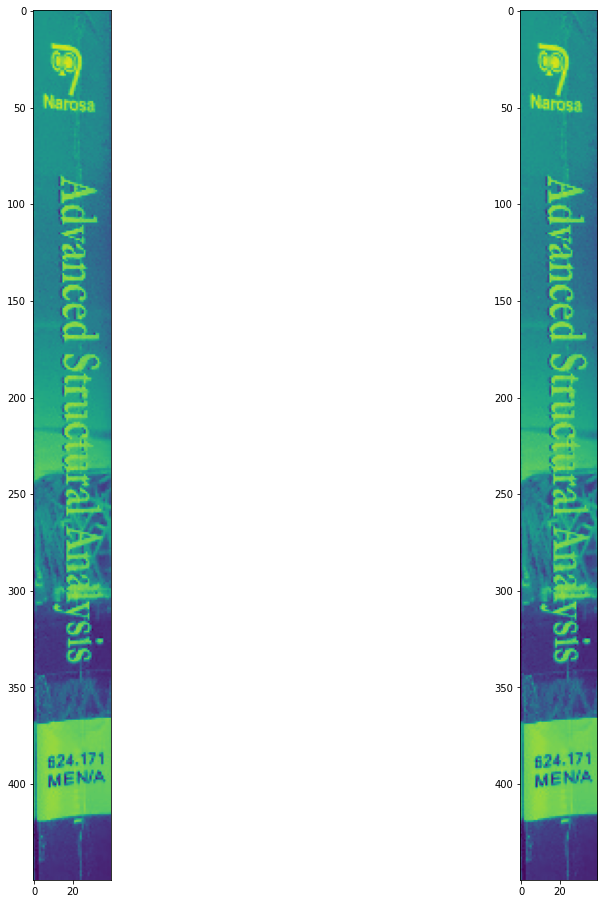

In [ ]:
rot = cv2.cvtColor(rot,cv2.COLOR_BGR2GRAY)
fig,axies = plt.subplots(1,2,figsize=(16,16))
for i,ax in enumerate(axies.flat):
  ax.imshow(rot)

In [ ]:
print(rot)

[[122 121 120 ... 115 110  92]
 [124 124 123 ... 107  97  90]
 [124 124 124 ... 101 110  81]
 ...
 [ 68  22  14 ...  32  30  30]
 [ 75  20  14 ...  32  33  32]
 [ 74  19  15 ...  33  32  31]]


In [ ]:
print(rot[0])
print(len(rot))
print(rot[375])
max_sum=0
min_sum=1e6
min_idx=0
idx=0
for i in range(0,450):
  if(np.sum(rot[i])<min_sum):
    min_sum = min(min_sum,np.sum(rot[i]))
    min_idx=i
  if(np.sum(rot[i])>max_sum):
    max_sum = np.sum(rot[i])
    idx = i

print(max_sum)
print(idx)
print(min_idx)
print(min_sum)
# this test concludes going with max would give more accurate results as 
# there is chance of presence of complet black outside of code box
# as there is chance of presence of complete white outside of the code box 
# but this has a higher cance of giving correct result

[122 121 120 122 124 124 122 123 121 123 119 119 119 122 125 116 111 116
 115 117 116 122 117 117 120 108 115 130 114 111 118 114 113 117 110 108
 110 115 110  92]
450
[150 116 180 178 182 185 187 189 189 191 191 186 182 182 182 180 179 180
 180 178 177 178 177 173 171 175 173 179 180 181 179 180 181 179 179 178
 178 177 176 174]
7155
378
444
1463


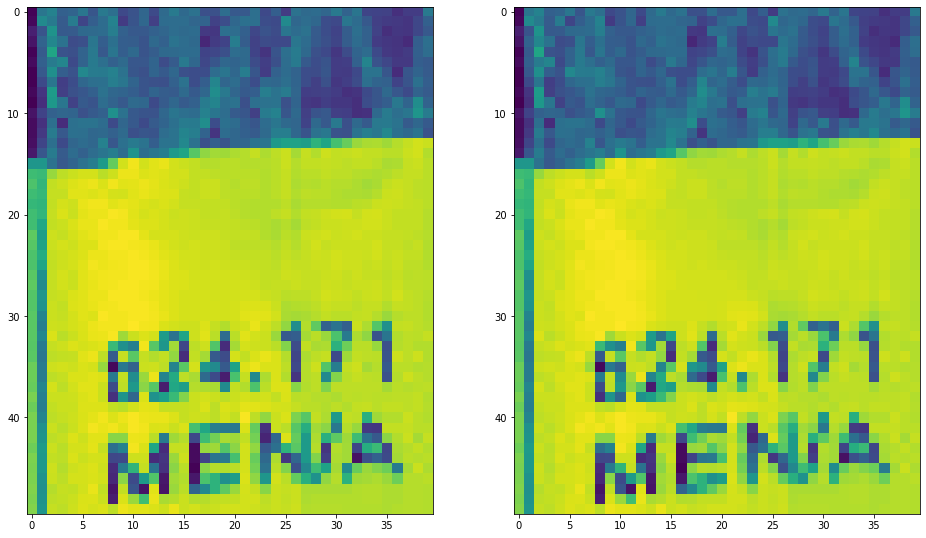

In [ ]:
# sticker is standard so the size is in the range of 50's
rot = rot[idx-25:idx+25,0:50]
rot.imwrite(f'Images/rot.jpeg',rot)
fig,axies = plt.subplots(1,2,figsize=(16,16))
for i,ax in enumerate(axies.flat):
  ax.imshow(rot)

In [3]:
#model for upsampling the quality of extracted image
from sklearn.model_selection import train_test_split
import keras
from tensorflow.keras import Model, Input, regularizers
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, UpSampling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import load_img, img_to_array 


In [5]:
import glob
Images = glob.glob('./Images/*.jpeg')

In [11]:
from tqdm import tqdm
all_images = []

for i in tqdm(Images):
  img = keras.utils.load_img(i, target_size=(80,80,3))
  img = keras.utils.img_to_array(img)
  all_images.append(img)


0it [00:00, ?it/s]


In [12]:
all_images = np.array(all_images)

In [ ]:
train_x, val_x = train_test_split(all_images, random_state=32, test_size=0.1)
     

In [14]:
def pixalate_image(image, scale_percent = 40):
  width = int(image.shape[1] * scale_percent / 100)
  height = int(image.shape[0] * scale_percent / 100)
  dim = (width, height)

  small_image = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)
  
  # scale back to original size
  width = int(small_image.shape[1] * 100 / scale_percent)
  height = int(small_image.shape[0] * 100 / scale_percent)
  dim = (width, height)

  low_res_image = cv2.resize(small_image, dim, interpolation = cv2.INTER_AREA)

  return low_res_image
     

In [ ]:
train_x_px = []

for i in range(train_x.shape[0]):
  temp = pixalate_image(train_x[i,:,:,:])
  train_x_px.append(temp)

train_x_px = np.array(train_x_px)


# get low resolution images for the validation set
val_x_px = []

for i in range(val_x.shape[0]):
  temp = pixalate_image(val_x[i,:,:,:])
  val_x_px.append(temp)

val_x_px = np.array(val_x_px)

In [ ]:
train_x = np.array(train_x)
val_x=np.array(val_x)

In [15]:
Input_img = Input(shape=(80, 80, 3))  

#encoding architecture
x1 = Conv2D(256, (3, 3), activation='relu', padding='same')(Input_img)
x2 = Conv2D(128, (3, 3), activation='relu', padding='same')(x1)
x2 = MaxPool2D( (2, 2))(x2)
encoded = Conv2D(64, (3, 3), activation='relu', padding='same')(x2)

# decoding architecture
x3 = Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
x3 = UpSampling2D((2, 2))(x3)
x2 = Conv2D(128, (3, 3), activation='relu', padding='same')(x3)
x1 = Conv2D(256, (3, 3), activation='relu', padding='same')(x2)
decoded = Conv2D(3, (3, 3), padding='same')(x1)

autoencoder = Model(Input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse')
     

In [16]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 80, 80, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 80, 80, 256)       7168      
                                                                 
 conv2d_1 (Conv2D)           (None, 80, 80, 128)       295040    
                                                                 
 max_pooling2d (MaxPooling2D  (None, 40, 40, 128)      0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 40, 40, 64)        73792     
                                                                 
 conv2d_3 (Conv2D)           (None, 40, 40, 64)        36928     
                                                             

In [ ]:

early_stopper = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=4, verbose=1, mode='auto')
a_e = autoencoder.fit(train_x_px, train_x,
            epochs=5,
            batch_size=10,
            shuffle=True,
            validation_data=(val_x_px, val_x),
            callbacks=[early_stopper])

In [ ]:
predictions = autoencoder.predict(val_x_px)

In [ ]:
cv2.imwrite('./text.jpeg',rot)

True

In [ ]:
pip install git+https://github.com/faustomorales/keras-ocr.git#egg=keras-ocr

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/faustomorales/keras-ocr.git to /tmp/pip-install-rcdfso6k/keras-ocr_94cb963d81884ea0bca0964c5f7f0811
  Running command git clone -q https://github.com/faustomorales/keras-ocr.git /tmp/pip-install-rcdfso6k/keras-ocr_94cb963d81884ea0bca0964c5f7f0811
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 619 kB 8.6 MB/s 
     |████████████████████████████████| 965 kB 58.0 MB/s 
     |████████████████████████████████| 9.5 MB 57.6 MB/s 
     |████████████████████████████████| 50 kB 6.4 MB/s 
  Created wheel for keras-ocr: filename=keras_ocr-0.0.0-py3-none-any.whl size=42294 sha256=4f7c079726160998e38c8b2664216d82bd66aa379b25efec210895db20bb7852
  Stored in directory: /tmp/pip-ephem-wheel-cache-hn4qu4pr/wheels/70/f2/de/35bd7967fc8f67ea69d02593d61b40117bc7fed

In [ ]:
import keras_ocr


In [ ]:
pipeline = keras_ocr.pipeline.Pipeline()

Looking for /root/.keras-ocr/craft_mlt_25k.h5
Looking for /root/.keras-ocr/crnn_kurapan.h5


In [ ]:
images = [
    keras_ocr.tools.read(img) for img in ['./text.jpeg']
]


In [ ]:
prediction_groups = pipeline.recognize(images)

1/1 [==============================] - 1s 719ms/step


In [ ]:
predicted_image = prediction_groups[0]
for text, box in predicted_image:
    print(text)

171
825
mena
